In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import math
import statsmodels.api as sm
import warnings
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf, keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential, load_model


InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

In [2]:
#Loading in Model and Data-Set for Exploration
model = load_model('CNN_model_1.h5')

#Read-In Data
df = pd.read_csv('20231031_AllGames_wAdvancedTracking.csv')
df_copy = df.copy()

#Read-In Supplemental Data
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
tackles = pd.read_csv('tackles.csv')

Metal device set to: Apple M1 Pro


2023-11-06 13:12:14.431531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 13:12:14.431664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Play Animator Function

In [3]:
def playAnimator(data, GAMEID, PLAYID):

    colors = [[0, 'lime'],
              [0.01, 'gray'],
              [0.02, 'black'],
              [0.2, 'red'],
              [0.4, 'orange'],
              [0.6, 'gold'],
              [0.8, 'yellow'],
              [1, 'white']]
    
    cmap = LinearSegmentedColormap.from_list('', colors)
    
    play_data = plays[(plays.gameId == GAMEID)&(plays.playId == PLAYID)]
    
    fig = fig = px.scatter(data, x = 'x', y = 'y', range_x = [0,120], range_y = [0, 53.3],
              color = 'Predictions', animation_frame = 'frameId', width=1000, height=565,
                          range_color = [0, 1], color_continuous_scale = colors)
    
    fig = fig.add_vrect(x0=0, x1=10, fillcolor = 'gray')
    fig = fig.add_vrect(x0=110, x1=120, fillcolor = 'gray')
    fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']), line_dash="dash", 
                        line_color="blue", opacity = 0.5)
    # fig = fig.add_vline(x = int(play_data['absoluteYardlineNumber']) - int(play_data['yardsToGo']),
    #                     line_dash="dash", line_color="gold", opacity = 0.5)
    fig = fig.update_layout(
        plot_bgcolor='#567D46'
    )
    fig = fig.update_yaxes(visible=False)
    fig = fig.update_layout(xaxis=dict(
        tick0=0,
        dtick=10,))
    
    fig = fig.update_traces(marker=dict(size=12,line=dict(width=2,color='black'), opacity=0.9),
                      selector=dict(mode='markers'))
    
    # Set frame duration to 100ms
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 130
    
    # Set transition xduration between frames to 0ms
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0
    
    return fig

### Data Pre-Processing to test accuracy of Model:

In [4]:
#Drop Columns that Can Lead to Memorizaton
df = df.drop(columns = ['gameId','playId','event','tackle_x','tackle_y','playTime'])

#One-Hot Encode "Position" Variable
df = df.join(pd.get_dummies(df['position'], dtype=float))
df = df.drop(columns = ['position'])

#Replacing playerType with defense
df.loc[(df.playerType != 'Offense')&(df.playerType != 'ballCarrier'), 'playerType'] = 'Defense'

#One-Hot Encode "playerType" Variable
df = df.join(pd.get_dummies(df['playerType'], dtype=float))
df = df.drop(columns = ['playerType'])

##Normalize the Data (MINMAX)
columns_to_normalize = ['x', 'y', 's', 'a', 'dis', 'o', 'dir','distance_to_ballCarrier']
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

##Normalize the Data (STANDARD)
columns_to_normalize = ['age', 'height','weight']
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df = df[['key', 'nflId', 'frameId', 'tackle', 'x', 'y', 's', 'a', 'dis', 'o', 'dir',
       'height', 'weight', 'age', 'distance_to_ballCarrier', 'C', 'CB',
       'DB', 'DE', 'DT', 'FB', 'FS', 'G', 'ILB', 'MLB', 'NT', 'OLB', 'QB',
       'RB', 'SS', 'T', 'TE', 'WR', 'Defense', 'Offense', 'ballCarrier']]

In [5]:
def run_play_through_model(KEY):
    max_frames = 127
    #Number of Players per Frame
    num_players = 22
    
    #Empty arrays for Input Data (X) and target data (y)
    X_test = []
    y_test = []
    
    play_data = df[df.key == KEY]
        
    #List of Frames for this Key
    frames = np.zeros((max_frames, 22, 32))
    tackle_labels = np.zeros((max_frames, 22))
    play_data = play_data.sort_values(by = ['frameId', 'nflId']).reset_index(drop = True)
    
    for frame in play_data['frameId'].unique():
        frame_data_acc = []
        tackle_label_acc = []
    
        frame_data_rows = play_data[play_data['frameId'] == frame]
        
        for _, row in frame_data_rows.iterrows():
            frame_data = row.iloc[4:].values
            frame_data_acc.append(frame_data)
            tackle_label_acc.append(row['tackle'])
    
        frame_data = np.stack(frame_data_acc, axis = 0)
        tackle_label = np.array(tackle_label_acc)
        
        frames[frame - 1] = frame_data
        tackle_labels[frame - 1] = tackle_label
    
    
        X_test.append(frames)
        y_test.append(tackle_labels)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_test = X_test[0:1]
    y_test = y_test[0:1]
    
    predictions = []
    for i in range(play_data['frameId'].max()):
        incoming = np.zeros((1, 127, 22, 32))
        incoming[0][:i] = X_test[0][:i]
    
        pred = model.predict(incoming, verbose = 0)
        predictions.append(pred)

    flat_list = []
    for sublist in predictions:
        for item in sublist:
            for value in item:
                flat_list.append(value)

    return flat_list

### Compile 100 Random Games for Testing

In [122]:
#Generates 100 Random Keys
key_list = list(df.key.sample(1000))
#Initializes Blank Data Frame to Store all 100 Play Predictions In
list_of_100 = pd.DataFrame()
i = 1

#Iterates through Each Key in the 100 Random Keys, Predicts
for KEY in key_list:
    #Get Predictions for Each Frame of the Random Play
    prediction_list = run_play_through_model(KEY)
    play_df = df[df.key == KEY].sort_values(by = ['frameId', 'nflId']).reset_index(drop = True)
    play_df['Predictions'] = prediction_list

    #Merge with the Copied DataFrame (This doesn't have Scaled Data)
    GAME_ID = int(str(play_df.key.unique())[1:11])
    PLAY_ID = int(str(play_df.key.unique())[11:-1])
    final_play_data = df_copy[(df_copy.gameId == GAME_ID)&(df_copy.playId == PLAY_ID)]

    #Compile File Data, Manually Set Offense and Ball Carrier to Low Prediciton Rate
    final_play_data.loc[(final_play_data.playerType != 'Offense')&(final_play_data.playerType != 'ballCarrier'), 'playerType'] = 'Defense'
    tackle_prob = play_df[['nflId','frameId','Predictions']]
    final_play_data = pd.merge(final_play_data, tackle_prob, on = ['nflId','frameId'])
    final_play_data.loc[(final_play_data.playerType == 'Defense') & (final_play_data.Predictions <= 0.02), 'Predictions'] =  0.02
    final_play_data.loc[(final_play_data.playerType == 'Offense'), 'Predictions']  = 0.01
    final_play_data.loc[(final_play_data.playerType == 'ballCarrier'), 'Predictions'] = 0

    list_of_100 = pd.concat([list_of_100, final_play_data])
    if i % 25 == 0:
        print(f'Completed Play {i} of 1000')
    i += 1

Completed Play 25 of 1000
Completed Play 50 of 1000
Completed Play 75 of 1000
Completed Play 100 of 1000
Completed Play 125 of 1000
Completed Play 150 of 1000
Completed Play 175 of 1000
Completed Play 200 of 1000
Completed Play 225 of 1000
Completed Play 250 of 1000
Completed Play 275 of 1000
Completed Play 300 of 1000
Completed Play 325 of 1000
Completed Play 350 of 1000
Completed Play 375 of 1000
Completed Play 400 of 1000
Completed Play 425 of 1000
Completed Play 450 of 1000
Completed Play 475 of 1000
Completed Play 500 of 1000
Completed Play 525 of 1000
Completed Play 550 of 1000
Completed Play 575 of 1000
Completed Play 600 of 1000
Completed Play 625 of 1000
Completed Play 650 of 1000
Completed Play 675 of 1000
Completed Play 700 of 1000
Completed Play 725 of 1000
Completed Play 750 of 1000
Completed Play 775 of 1000
Completed Play 800 of 1000
Completed Play 825 of 1000
Completed Play 850 of 1000
Completed Play 875 of 1000
Completed Play 900 of 1000
Completed Play 925 of 1000
Comp

In [123]:
top_preds = list_of_100.groupby(['gameId', 'playId', 'frameId'], as_index = False)['Predictions'].max()

In [124]:
top_preds = pd.merge(list_of_100, top_preds, on = ['gameId','playId','frameId','Predictions'], how = 'inner')

In [125]:
print('Number of Unique Plays: ', top_preds['key'].nunique())
print('Number of Plays with tackler identified as top prediction (anytime during play): ', top_preds[top_preds.tackle == 1]['key'].nunique())

highest_mean = top_preds.groupby(['gameId','playId','nflId'], as_index = False)['Predictions'].mean()
top_mean = highest_mean.groupby(['gameId','playId'], as_index = False)['Predictions'].max()
highest_mean = pd.merge(highest_mean, top_mean, on = ['gameId','playId', 'Predictions'], how = 'inner')
highest_mean = pd.merge(top_preds, highest_mean, on = ['gameId','playId','nflId'], how = 'inner', suffixes = (['','_mean']))

print('Number of Plays with tackler identified as top average prediction: ', highest_mean[highest_mean.tackle == 1]['key'].nunique())

Number of Unique Plays:  945
Number of Plays with tackler identified as top prediction (anytime during play):  885
Number of Plays with tackler identified as top average prediction:  726


In [168]:
max_per_key = top_preds.groupby(['key'], as_index = False)['frameId'].max().rename(columns = {'frameId':'playLength'})
top_preds = pd.merge(top_preds, max_per_key, on = ['key'], how = 'outer')
top_preds['Percent of Play Completed'] = round(top_preds['frameId'] / top_preds['playLength'] * 100, 0)

In [224]:
plays['key'] = plays['gameId'].astype('str') + plays['playId'].astype('str')
plays['key'] = plays['key'].astype('int')
play_type = plays[['key', 'defendersInTheBox', 'offenseFormation']]
top_preds = pd.merge(top_preds, play_type, on = 'key')

In [420]:
palette = ["#001219", "#005F73", "#0A9396", "#94D2BD", "#E9D8A6", 
           "#EE9B00", "#CA6702", "#BB3E03", "#AE2012"]

colors_full = sns.color_palette(palette, 9)

palette = ["#001219", "#005F73", "#0A9396", "#E9D8A6", 
           "#EE9B00", "#CA6702", "#BB3E03", "#AE2012"]

colors_partial = sns.color_palette(palette, 8)

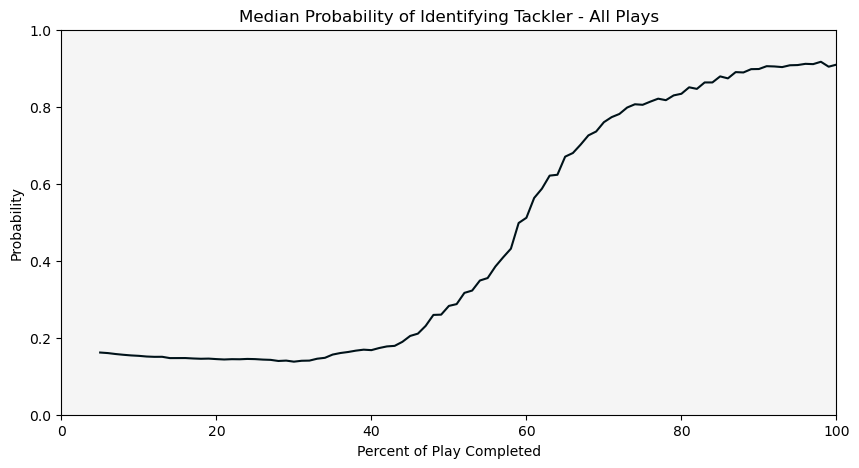

In [421]:
#All 
data = top_preds[top_preds.tackle == 1].groupby(['Percent of Play Completed'], as_index = False)['Predictions',].median()
data['Smoothed_Y'] = data['Predictions'].rolling(window=5).mean()

fig, axes = plt.subplots(figsize = (10, 5))
ax = sns.lineplot(data = data, x = 'Percent of Play Completed', y = 'Smoothed_Y', 
                  estimator = np.median, color = '#001219')

title = ax.set_title('Median Probability of Identifying Tackler - All Plays')
y_axis = ax.set_ylabel('Probability')
ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(0, 100)
bg = ax.set_facecolor('#F5F5F5')

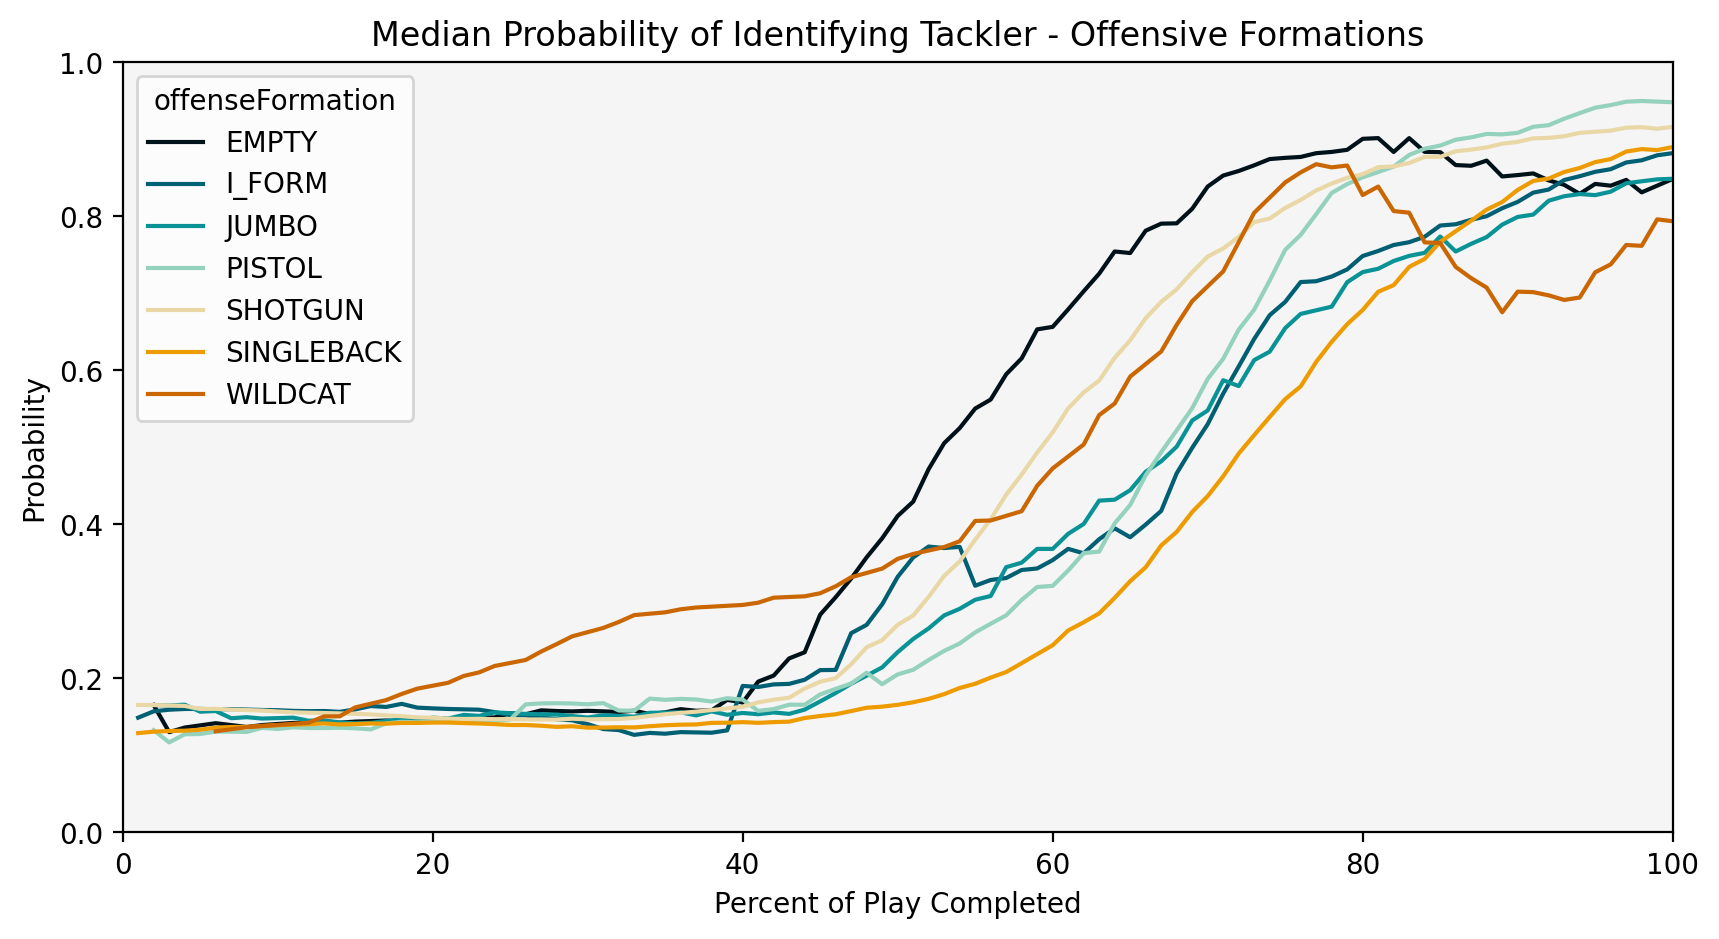

In [627]:
data = top_preds[top_preds.tackle == 1].groupby(['offenseFormation','Percent of Play Completed'], as_index = False)['Predictions',].median()
window_size = 5
data['rolling_preds'] = data.groupby('offenseFormation')['Predictions'].rolling(window=15, min_periods=1).mean().reset_index(drop=True)

fig, axes = plt.subplots(figsize = (10, 5), dpi = 200)
ax = sns.lineplot(data = data, x = 'Percent of Play Completed', y = 'rolling_preds', 
                  estimator = np.median, hue = 'offenseFormation', palette = colors_full, ci = None)

title = ax.set_title('Median Probability of Identifying Tackler - Offensive Formations')
y_axis = ax.set_ylabel('Probability')
ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(0, 100)
bg = ax.set_facecolor('#F5F5F5')

plt.savefig('./Images/offensive_formations.png', format='png', dpi=300, transparent=True)

In [1]:
data = top_preds[top_preds.tackle == 1].groupby(['defendersInTheBox','Percent of Play Completed'], as_index = False)['Predictions',].median()
window_size = 5
data['rolling_preds'] = data.groupby('defendersInTheBox')['Predictions'].rolling(window=15, min_periods=1).mean().reset_index(drop=True)

fig, axes = plt.subplots(figsize = (10, 5))
ax = sns.lineplot(data = data, x = 'Percent of Play Completed', y = 'rolling_preds', 
                  estimator = np.median, color = 'coral', hue = 'defendersInTheBox', palette = colors_full, ci = None)

title = ax.set_title('Median Probability of Identifying Tackler - Defensive Formations')
y_axis = ax.set_ylabel('Probability')
ylim = ax.set_ylim(0, 1)
xlim = ax.set_xlim(0, 100)
bg = ax.set_facecolor('#F5F5F5')

NameError: name 'top_preds' is not defined

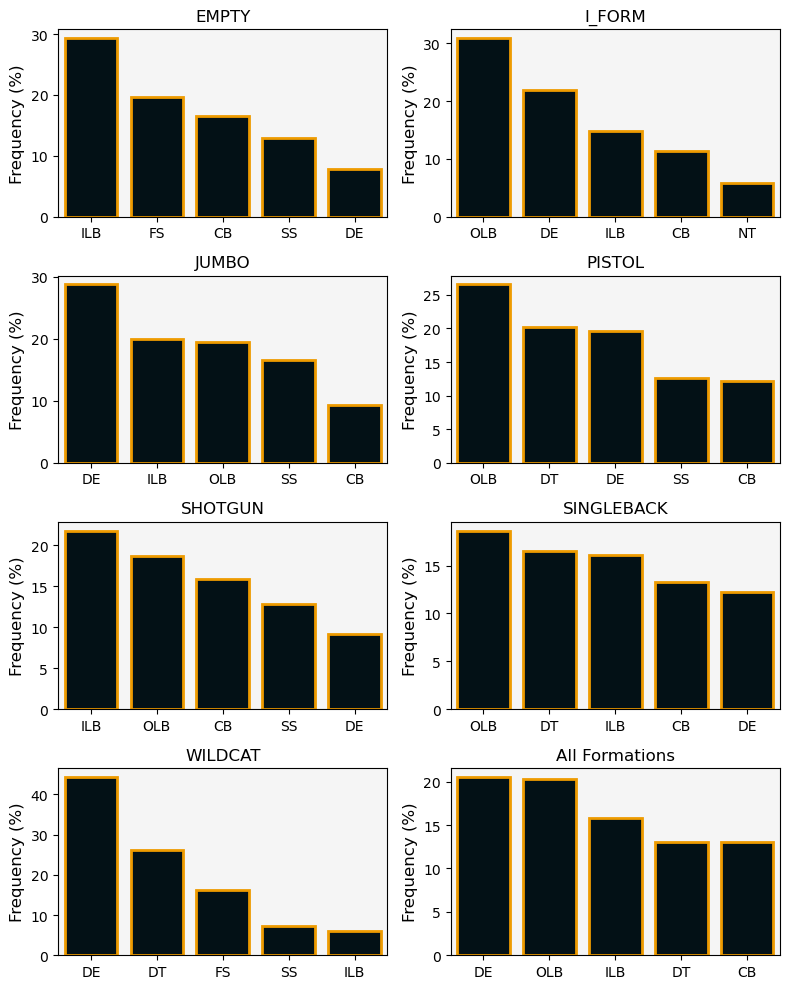

In [636]:
offense_preds = top_preds[top_preds.tackle == 1].groupby(['offenseFormation'], as_index = False)['position',].value_counts(normalize = True)

fig, axes = plt.subplots(4, 2, figsize = (8,10))

for i, formation in enumerate(offense_preds['offenseFormation'].unique()):
    data_ = offense_preds[offense_preds.offenseFormation == formation].sort_values(by = ['position'])
    data_['proportion'] = data_['proportion'] * 100
    data_ = data_[data_['proportion'].isin(data_['proportion'].nlargest().to_list())]

    ax = axes[i // 2, i % 2]

    ax = sns.barplot(data_.sort_values('proportion', ascending = False), x = 'position', y = 'proportion', 
                     ax = ax, color = palette[0], edgecolor = palette[4], linewidth = 2)
    
    title = ax.set_title(f'{formation}', size = 12)
    bg = ax.set_facecolor('#F5F5F5')
    y_axis = ax.set_ylabel('Frequency (%)', size = 12)
    x_axis = ax.set_xlabel('')

data_ = offense_preds.groupby(['position'], as_index = False)['proportion'].mean().sort_values(by = ['position'])
data_['proportion'] = data_['proportion'] * 100
data_ = data_[data_['proportion'].isin(data_['proportion'].nlargest().to_list())]

ax = axes[-1, -1]
ax = sns.barplot(data_.sort_values('proportion', ascending = False), x = 'position', y = 'proportion', 
                     ax = ax, color = palette[0], edgecolor = palette[4], linewidth = 2)
title = ax.set_title(f'All Formations', size = 12)
bg = ax.set_facecolor('#F5F5F5')
y_axis = ax.set_ylabel('Frequency (%)', size = 12)
x_axis = ax.set_xlabel('')

#big_title = plt.suptitle('Frequency of Predictions by Position for Offensive Formations', size = 20)


fig.tight_layout()

plt.savefig('./Images/offensive_formations_preds.png', format='png', dpi=300, transparent=True)

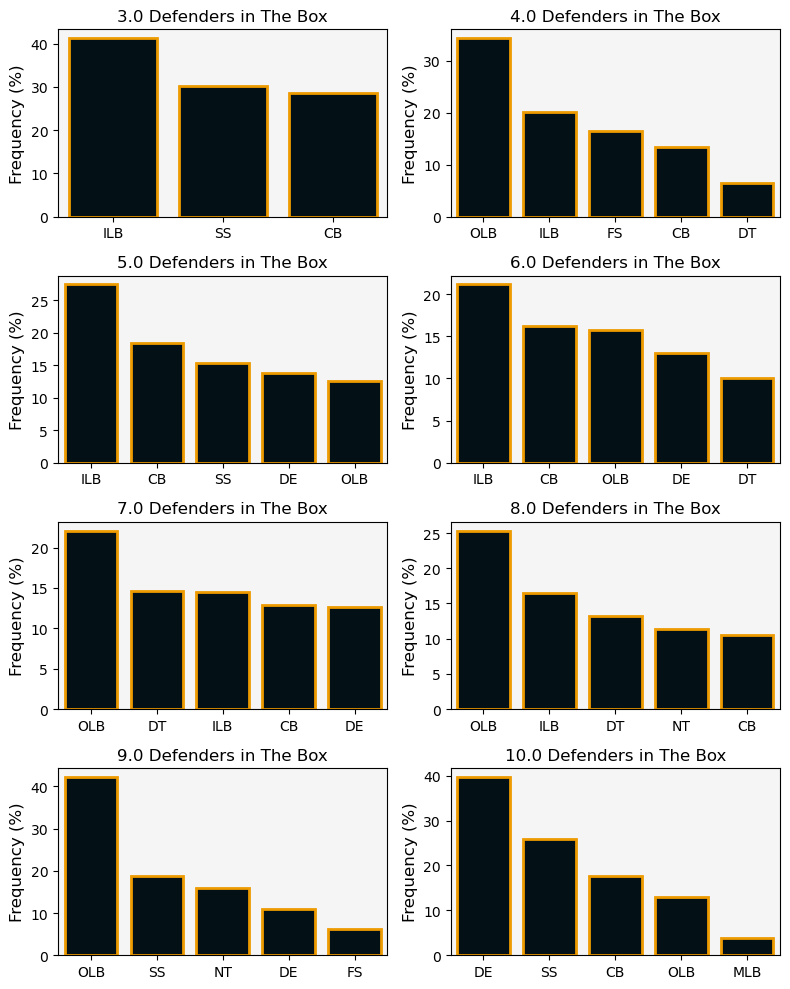

In [642]:
deffensive = top_preds[top_preds.tackle == 1].groupby(['defendersInTheBox'], as_index = False)['position',].value_counts(normalize = True)

fig, axes = plt.subplots(4, 2, figsize = (8,10))

for i, formation in enumerate(deffensive['defendersInTheBox'].unique()[0:8]):
    data_ = deffensive[deffensive.defendersInTheBox == formation].sort_values(by = ['position'])
    data_['proportion'] = data_['proportion'] * 100
    data_ = data_[data_['proportion'].isin(data_['proportion'].nlargest().to_list())]

    ax = axes[i // 2, i % 2]

    ax = sns.barplot(data_.sort_values('proportion', ascending = False), x = 'position', y = 'proportion', 
                     ax = ax, color = palette[0], edgecolor = palette[4], linewidth = 2)
    
    title = ax.set_title(f'{formation} Defenders in The Box', size = 12)
    bg = ax.set_facecolor('#F5F5F5')
    y_axis = ax.set_ylabel('Frequency (%)', size = 12)
    x_axis = ax.set_xlabel('')

# data_ = offense_preds.groupby(['position'], as_index = False)['proportion'].mean().sort_values(by = ['position'])
# data_['proportion'] = data_['proportion'] * 100
# data_ = data_[data_['proportion'].isin(data_['proportion'].nlargest().to_list())]

# ax = axes[-1, -1]
# ax = sns.barplot(data_.sort_values('proportion', ascending = False), x = 'position', y = 'proportion', 
#                      ax = ax, color = palette[0], edgecolor = palette[4], linewidth = 2)
# title = ax.set_title(f'All Formations', size = 12)
# bg = ax.set_facecolor('#F5F5F5')
# y_axis = ax.set_ylabel('Frequency (%)',size = 12)
# x_axis = ax.set_xlabel('')

#big_title = plt.suptitle('Frequency of Predictions by Position for Defensive Formations', size = 20)


fig.tight_layout()
plt.savefig('./Images/defensive_formations_preds.png', format='png', dpi=300, transparent=True)

In [499]:
top_preds

,gameId,playId,nflId,frameId,playerType,x,y,s,a,dis,...,position,age,tackle_x,tackle_y,distance_to_ballCarrier,Predictions,playLength,Percent of Play Completed,defendersInTheBox,offenseFormation
0,2022092501,1377,43497.0,42,Defense,101.50,13.79,2.83,2.73,0.29,...,ILB,28.0,96.65,6.13,0.827103,0.327255,65,65.0,7.0,JUMBO
1,2022092501,1377,43497.0,43,Defense,101.53,13.53,2.57,2.68,0.26,...,ILB,28.0,96.65,6.13,1.024597,0.604868,65,66.0,7.0,JUMBO
2,2022092501,1377,43497.0,44,Defense,101.55,13.31,2.17,2.76,0.22,...,ILB,28.0,96.65,6.13,1.264002,0.795467,65,68.0,7.0,JUMBO
3,2022092501,1377,43497.0,45,Defense,101.57,13.11,1.85,2.73,0.20,...,ILB,28.0,96.65,6.13,1.517267,0.909224,65,69.0,7.0,JUMBO
4,2022092501,1377,43497.0,46,Defense,101.59,12.94,1.57,2.69,0.17,...,ILB,28.0,96.65,6.13,1.806018,0.921948,65,71.0,7.0,JUMBO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50621,2022102304,2812,54470.0,67,Defense,102.07,17.28,1.21,4.17,0.14,...,OLB,27.0,100.02,17.96,2.159838,0.634780,71,94.0,8.0,SINGLEBACK
50622,2022102304,2812,54470.0,68,Defense,101.98,17.24,0.76,4.12,0.10,...,OLB,27.0,100.02,17.96,2.308679,0.697186,71,96.0,8.0,SINGLEBACK
50623,2022102304,2812,54470.0,69,Defense,101.93,17.23,0.47,3.27,0.05,...,OLB,27.0,100.02,17.96,2.378445,0.749713,71,97.0,8.0,SINGLEBACK
50624,2022102304,2812,54470.0,70,Defense,101.89,17.24,0.37,2.20,0.04,...,OLB,27.0,100.02,17.96,2.487609,0.722097,71,99.0,8.0,SINGLEBACK


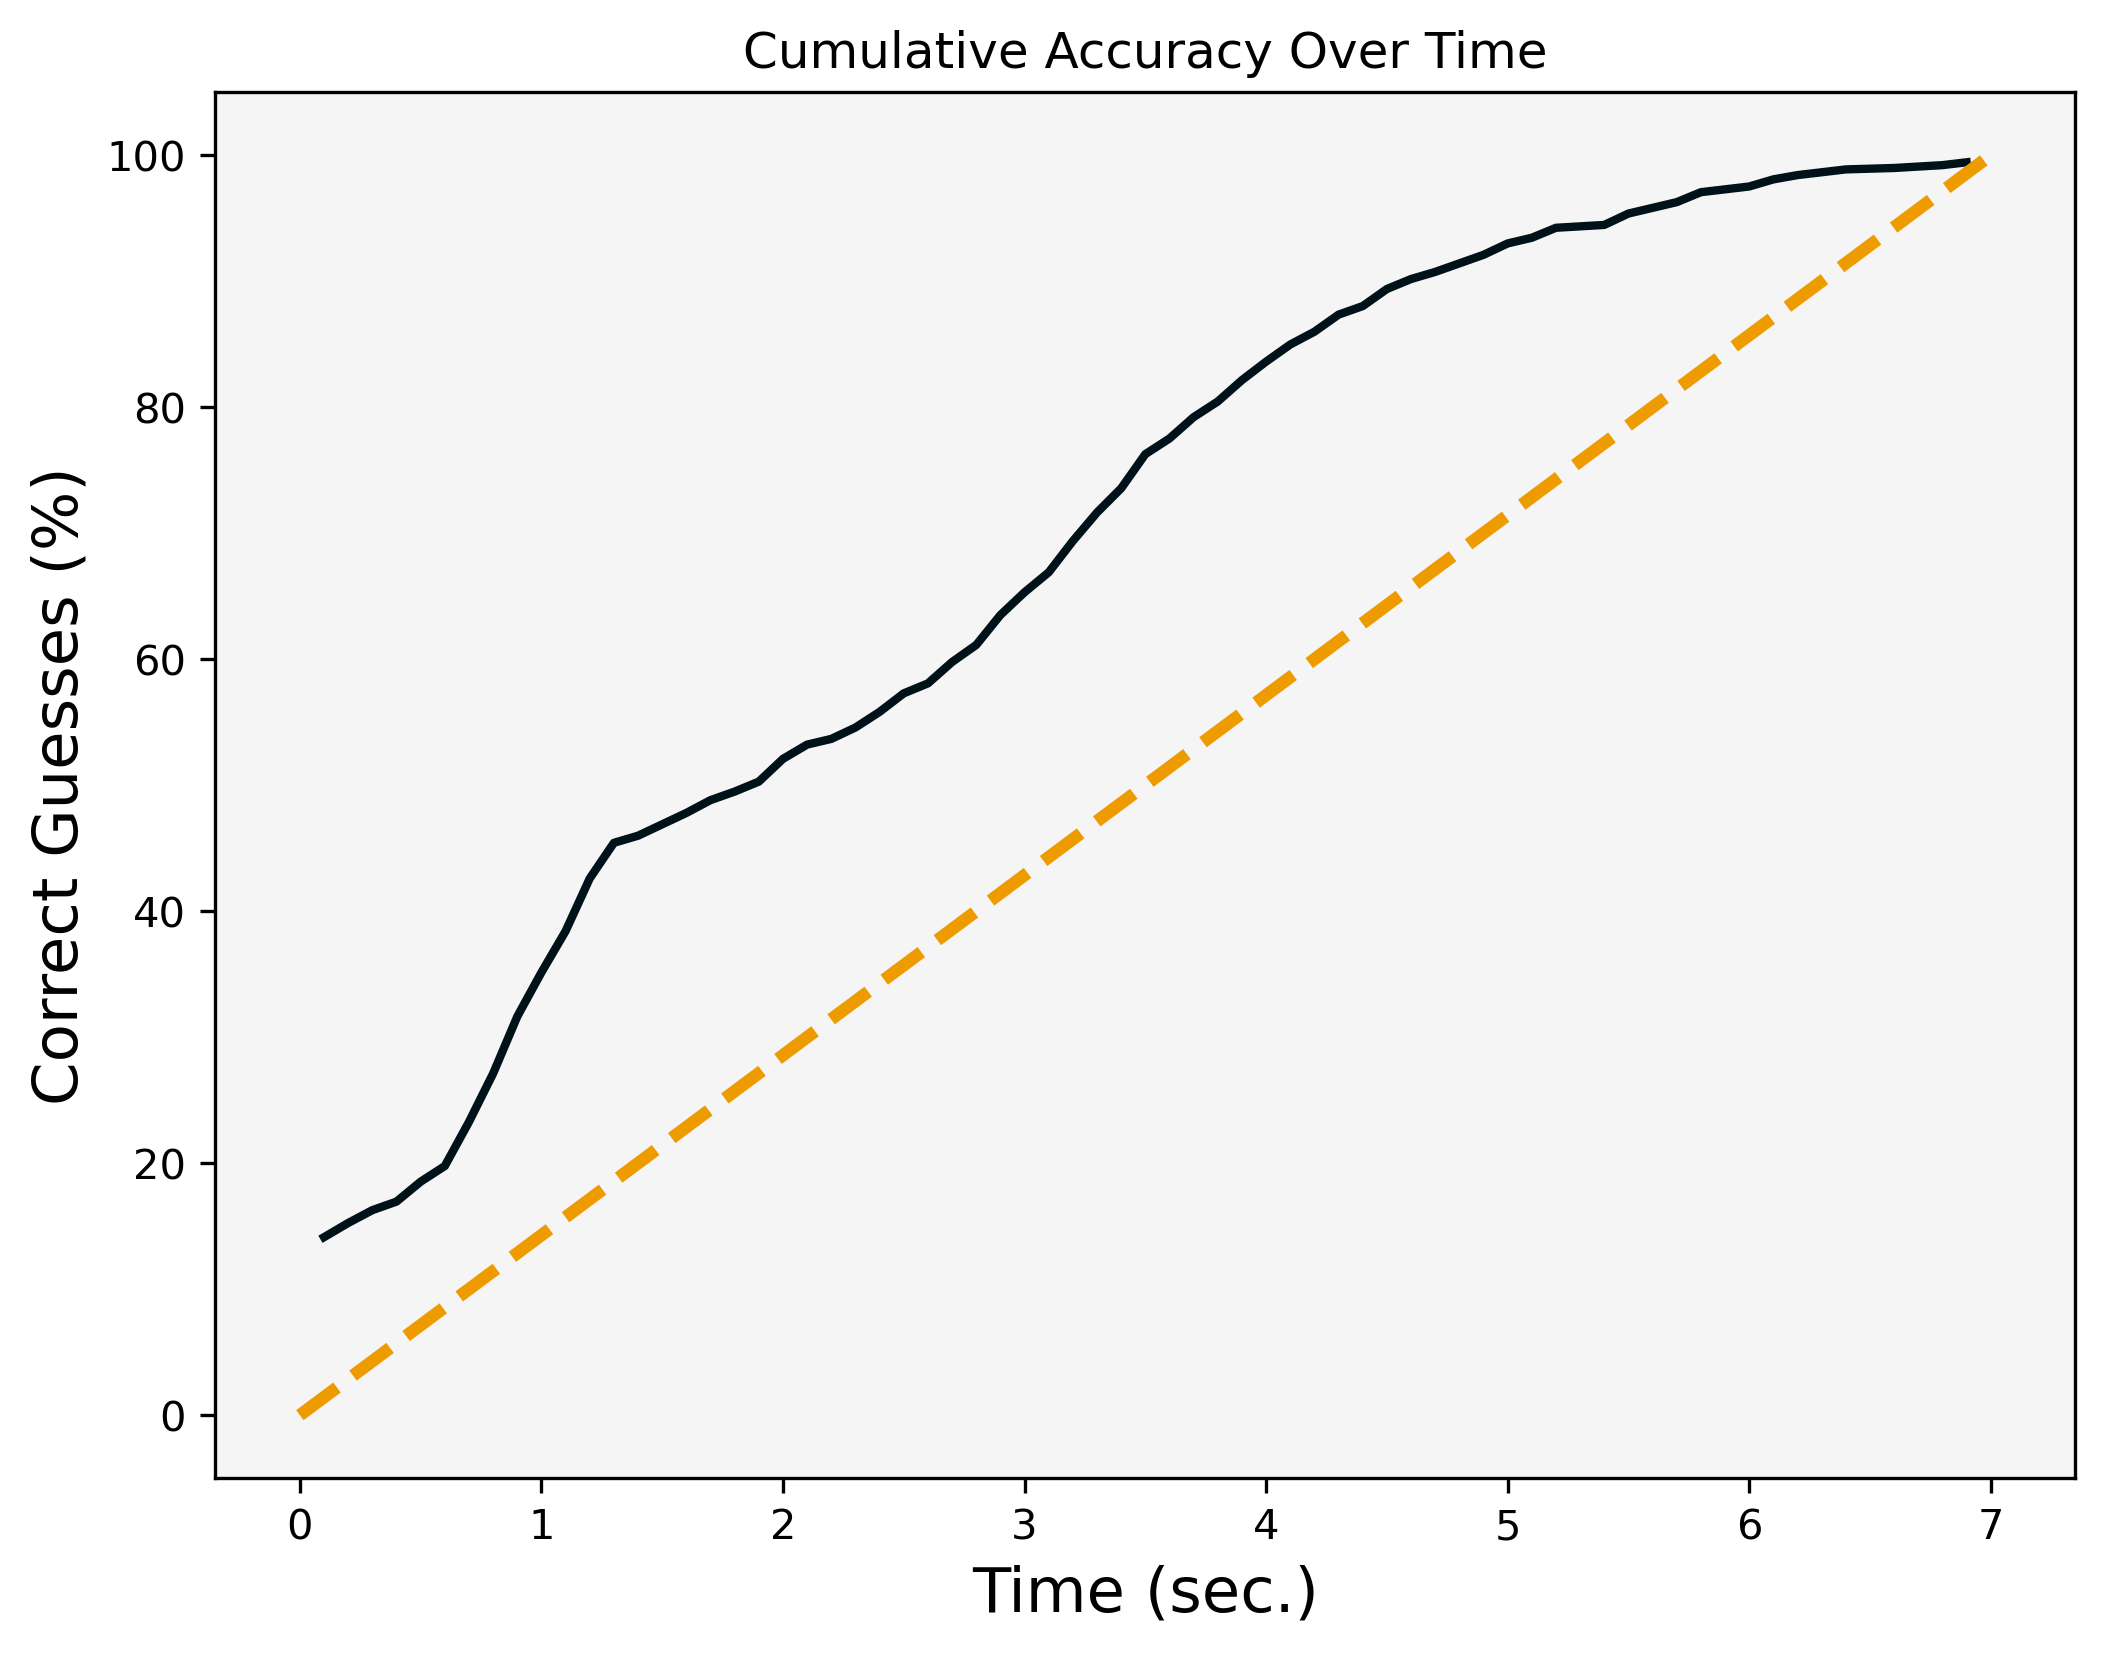

In [626]:
data = top_preds[top_preds.tackle == 1].groupby(['key'], as_index = False)['frameId', ].min()
data = pd.DataFrame(data['frameId'].value_counts()).reset_index().sort_values('frameId')
data['frameId'] = data['frameId']/ 10
data['cum_completed'] = data['count'] / data['count'].sum() * 100
data['cum_completed'] = data['cum_completed'].cumsum()

data = data[data.frameId < 7]
fig, axes = plt.subplots(figsize=(8,6), dpi = 300)
ax = sns.lineplot(data, x = 'frameId', y = 'cum_completed', color = "#001219", linewidth = 2)

title = ax.set_title(f'Cumulative Accuracy Over Time')
bg = ax.set_facecolor('#F5F5F5')
y_axis = ax.set_ylabel('Correct Guesses (%)', size = 15)
x_axis = ax.set_xlabel('Time (sec.)', size = 15)
linear = plt.plot([0, 7], [0, 100], linestyle = 'dashed', color = '#EE9B00', linewidth = 3)

plt.savefig('./Images/cum_acc.png', format='png', dpi=300, transparent=True)

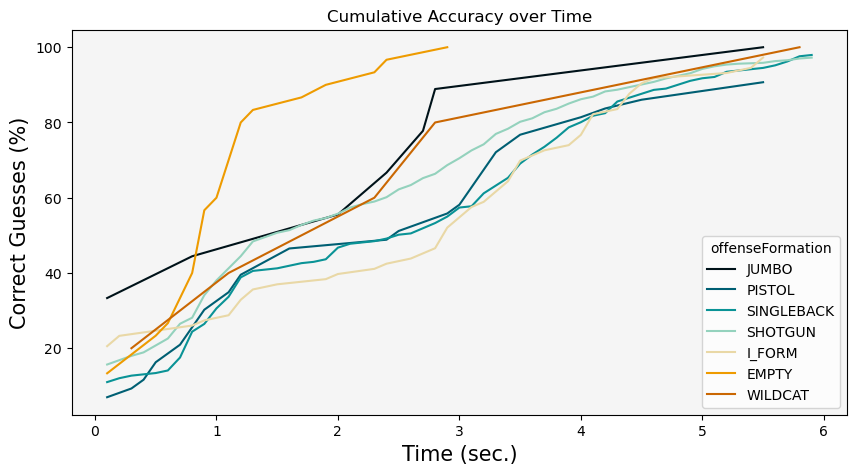

In [639]:
data_ = pd.DataFrame()
for formation in list(top_preds['offenseFormation'].unique()):
    data = top_preds[(top_preds.tackle == 1)&(top_preds['offenseFormation'] == formation)].groupby(['key'], as_index = False)['frameId', ].min()
    data = pd.DataFrame(data['frameId'].value_counts()).reset_index().sort_values('frameId')
    data['frameId'] = data['frameId']/ 10
    data['cum_completed'] = data['count'] / data['count'].sum() * 100
    data['cum_completed'] = data['cum_completed'].cumsum()
    data['offenseFormation'] = formation
    data_  = pd.concat([data_, data])

data_ = data_[data_.frameId < 6]
fig, axes = plt.subplots(figsize=(10,5))
ax = sns.lineplot(data_, x = 'frameId', y = 'cum_completed', hue = 'offenseFormation', palette = colors_full)

title = ax.set_title(f'Cumulative Accuracy over Time')
bg = ax.set_facecolor('#F5F5F5')
y_axis = ax.set_ylabel('Correct Guesses (%)', size = 15)
x_axis = ax.set_xlabel('Time (sec.)', size = 15)


plt.savefig('./Images/offensive_formations_acc.png', format='png', dpi=300, transparent=True)

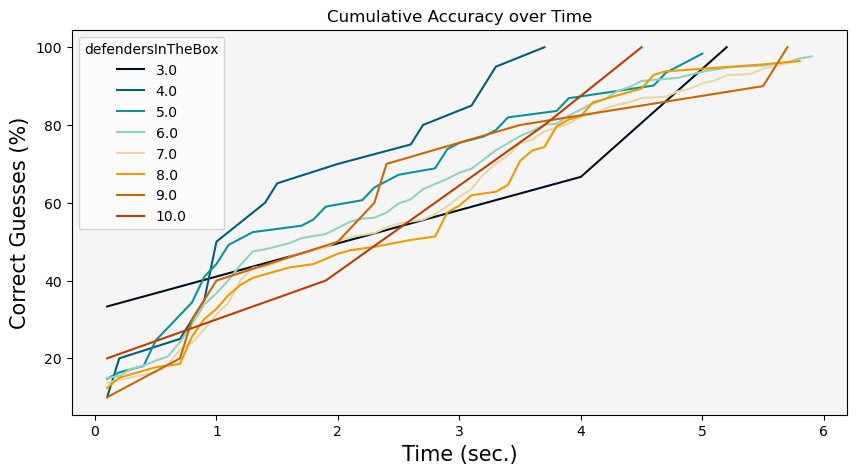

In [646]:
data_ = pd.DataFrame()
for formation in list(top_preds['defendersInTheBox'].unique()):
    data = top_preds[(top_preds.tackle == 1)&(top_preds['defendersInTheBox'] == formation)].groupby(['key'], as_index = False)['frameId', ].min()
    data = pd.DataFrame(data['frameId'].value_counts()).reset_index().sort_values('frameId')
    data['frameId'] = data['frameId']/ 10
    data['cum_completed'] = data['count'] / data['count'].sum() * 100
    data['cum_completed'] = data['cum_completed'].cumsum()
    data['defendersInTheBox'] = formation
    data_  = pd.concat([data_, data])


fig, axes = plt.subplots(figsize=(10,5))
data_ = data_[data_.frameId < 6]
data_ = data_[data_.defendersInTheBox!= 11]
ax = sns.lineplot(data_, x = 'frameId', y = 'cum_completed', hue = 'defendersInTheBox', palette = colors_full)

title = ax.set_title(f'Cumulative Accuracy over Time')
bg = ax.set_facecolor('#F5F5F5')
y_axis = ax.set_ylabel('Correct Guesses (%)', size = 15)
x_axis = ax.set_xlabel('Time (sec.)', size = 15)


plt.savefig('./Images/defensive_formations_acc.png', format='png', dpi=300, transparent=True)

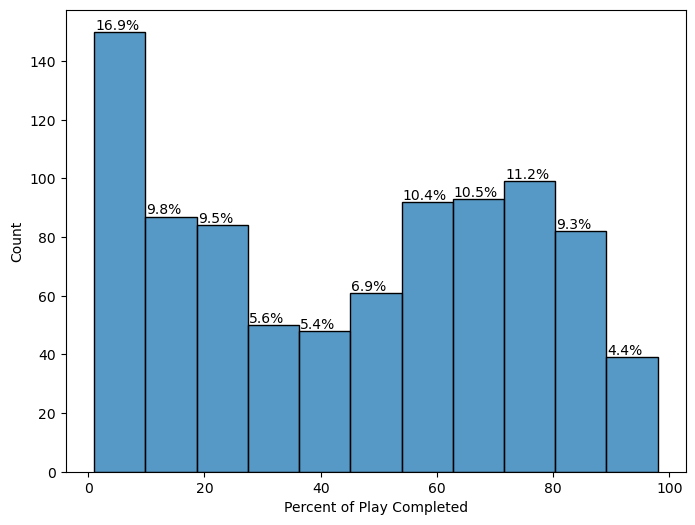

In [526]:
test = top_preds[top_preds['tackle'] == 1].groupby(['key'])['Percent of Play Completed',].min().reset_index()
fix, axes = plt.subplots(figsize = (8, 6))
ax = sns.histplot(test, x = 'Percent of Play Completed')
total = len(test['Percent of Play Completed'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + 0.2
    y = p.get_y() + p.get_height() + 0.8
    percent = ax.annotate(percentage, (x,y))